<a href="https://colab.research.google.com/github/jsedoc/ConceptorDebias/blob/master/EEC_with_CN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load EEC

In [1]:
!wget http://www.saifmohammad.com/WebDocs/EEC/Equity-Evaluation-Corpus.zip

--2019-03-03 16:02:02--  http://www.saifmohammad.com/WebDocs/EEC/Equity-Evaluation-Corpus.zip
Resolving www.saifmohammad.com (www.saifmohammad.com)... 192.185.17.122
Connecting to www.saifmohammad.com (www.saifmohammad.com)|192.185.17.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102568 (100K) [application/zip]
Saving to: ‘Equity-Evaluation-Corpus.zip’

Equity-Evaluation-C 100%[===================>] 100.16K   545KB/s    in 0.2s    

2019-03-03 16:02:02 (545 KB/s) - ‘Equity-Evaluation-Corpus.zip’ saved [102568/102568]



In [2]:
!unzip Equity-Evaluation-Corpus.zip

Archive:  Equity-Evaluation-Corpus.zip
  inflating: Equity-Evaluation-Corpus.csv  
  inflating: README.txt              


In [3]:
import numpy as np
import scipy, requests, codecs, os, re, nltk, itertools, csv
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering, KMeans
import tensorflow as tf
from scipy.stats import spearmanr
import pandas as pd
import functools as ft
import os
import io
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
EEC = pd.read_csv('/content/Equity-Evaluation-Corpus.csv', header=0)

In [0]:
EEC[0:5]


,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious
2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated
3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged
4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed


# Load GloVe embeddings

In [0]:
import gensim
from gensim.models.keyedvectors import KeyedVectors

In [5]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1Ty2exMyi-XOufY-v81RJfiPvnintHuy2

Downloading...
From: https://drive.google.com/uc?id=1Ty2exMyi-XOufY-v81RJfiPvnintHuy2
To: /content/gensim_glove.840B.300d.txt.bin
2.65GB [00:48, 54.5MB/s]


In [8]:
glove = KeyedVectors.load_word2vec_format('/content/' + 'gensim_glove.840B.300d.txt.bin', binary=True)
print('The glove embedding has been loaded!')

The glove embedding has been loaded!


# Load Word2vec embeddings
CN performed better using word2vec embeddings. For all 4 sentiments, CN showed improvements on debiasing gender bias.
If using GloVe embeddings, CN showed improvements on anger, fear and joy. For the sentiment 'sadness', CN gave a higher gender difference. However, by my observations, results can be improved if using more female and male names to find conceptors. So with a larger name datasets, the results of 'sadness' may also show improvements on debiasing.

In [9]:
!gdown https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM

Downloading...
From: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
To: /content/GoogleNews-vectors-negative300.bin.gz
1.65GB [00:13, 120MB/s]


In [0]:
!gunzip /content/GoogleNews-vectors-negative300.bin.gz

In [11]:
word2vec = KeyedVectors.load_word2vec_format('/content/' + 'GoogleNews-vectors-negative300.bin', binary=True)
print('The word2vec embedding has been loaded!')

The word2vec embedding has been loaded!


# Load fasttext

In [12]:
!gdown https://drive.google.com/uc?id=1Zl6a75Ybf8do9uupmrJWKQMnvqqme4fh

Downloading...
From: https://drive.google.com/uc?id=1Zl6a75Ybf8do9uupmrJWKQMnvqqme4fh
To: /content/fasttext.bin
2.42GB [00:42, 56.6MB/s]


In [13]:
fasttext = KeyedVectors.load_word2vec_format('/content/' + 'fasttext.bin', binary=True)
print('The fasttext embedding has been loaded!')

The fasttext embedding has been loaded!


# Load gender, racial name lists


In [0]:
## Gender name lists
!wget https://www.cs.cmu.edu/Groups/AI/areas/nlp/corpora/names/male.txt
!wget https://www.cs.cmu.edu/Groups/AI/areas/nlp/corpora/names/female.txt

--2019-03-02 22:49:24--  https://www.cs.cmu.edu/Groups/AI/areas/nlp/corpora/names/male.txt
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20466 (20K) [text/plain]
Saving to: ‘male.txt’

male.txt            100%[===================>]  19.99K  --.-KB/s    in 0.07s   

2019-03-02 22:49:25 (271 KB/s) - ‘male.txt’ saved [20466/20466]

--2019-03-02 22:49:26--  https://www.cs.cmu.edu/Groups/AI/areas/nlp/corpora/names/female.txt
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35751 (35K) [text/plain]
Saving to: ‘female.txt’

female.txt          100%[===================>]  34.91K  --.-KB/s    in 0.07s   

2019-03-02 22:49:27 (471 KB/s) - ‘female.txt’ saved [35751/35751]



In [14]:
## Racial names lists
!wget https://gist.githubusercontent.com/mbejda/61eb488cec271086632d/raw/6340b8045b28c2abc0b1d44cfbc80f40284ef890/Black-Male-Names.csv
!wget https://gist.githubusercontent.com/mbejda/6c2293ba3333b7e76269/raw/60aa0c95e8ee9b11b915a26f47480fef5c3203ed/White-Male-Names.csv
!wget https://gist.githubusercontent.com/mbejda/26ad0574eda7fca78573/raw/6936d1a8f5fa5220f2f60a51a06a35b172c50f93/White-Female-Names.csv
!wget https://gist.githubusercontent.com/mbejda/9dc89056005a689a6456/raw/bb6ef2375f1289d0ef10dbd8e9469670ac23ceab/Black-Female-Names.csv

--2019-03-03 16:14:59--  https://gist.githubusercontent.com/mbejda/61eb488cec271086632d/raw/6340b8045b28c2abc0b1d44cfbc80f40284ef890/Black-Male-Names.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 921600 (900K) [text/plain]
Saving to: ‘Black-Male-Names.csv’

Black-Male-Names.cs 100%[===================>] 900.00K  --.-KB/s    in 0.04s   

2019-03-03 16:14:59 (20.1 MB/s) - ‘Black-Male-Names.csv’ saved [921600/921600]

--2019-03-03 16:15:00--  https://gist.githubusercontent.com/mbejda/6c2293ba3333b7e76269/raw/60aa0c95e8ee9b11b915a26f47480fef5c3203ed/White-Male-Names.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)

# Get frequency list (used in calculating sentence embeddings)

In [15]:
!git clone https://github.com/PrincetonML/SIF

Cloning into 'SIF'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 2.80 MiB | 6.48 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [0]:
wikiWordsPath = '/content' + '/SIF/auxiliary_data/enwiki_vocab_min200.txt' # https://github.com/PrincetonML/SIF/blob/master/auxiliary_data/enwiki_vocab_min200.txt

frequencies = {}
with open(wikiWordsPath, "r+") as f_in:
    for line in f_in:
        frequencies[line.split(' ')[0]] = float(line.split(' ')[1])

# Load white/black names

In [0]:
# This is for male names, don't run it when testing on female tasks
word_list_male = []

In [0]:

f = open('/content/White-Male-Names.csv', 'r+')
f.readline()
i=0
for line in f:
  i +=1
  word_list_male.append(line.rstrip().split(',')[1].split(' ')[1])
  if i>=2400:
    break
f.close()
f = open('/content/Black-Male-Names.csv', 'r+')
i=0
f.readline()
for line in f:
  i+=1
  word_list_male.append(line.rstrip().split(',')[1].split(' ')[1])
  if i>=2400:
    break
f.close()

In [19]:
len(word_list_male)

4800

In [0]:
# This is for female names, don't run it when testing on male tasks

word_list_female = []

In [0]:
f = open('/content/White-Female-Names.csv', 'r+')
f.readline()
i =0 
for line in f:
  i+=1
  word_list_female.append(line.rstrip().split(',')[1].split(' ')[1])
  if i>=2400:
    break
f.close()
f = open('/content/Black-Female-Names.csv', 'r+')
f.readline()
i = 0
for line in f:
  i+=1
  word_list_female.append(line.rstrip().split(',')[1].split(' ')[1])
  if i>=2400:
    break
f.close()

In [22]:
len(word_list_female)

4800

# Load gender names(Not used in Racial Debiasing)

In [0]:
#load names from larger name dataset
f = open('/content/male.txt', 'r+')
i = 0
word_list= []
for line in f:
  i+=1
  if i < 7:
    continue
  token = line.split()
  word_list.append(token[0])
f.close()

In [0]:
#load names from larger name dataset
f = open('/content/female.txt', 'r+')
i = 0
for line in f:
  i+=1
  if i < 7:
    continue
  token = line.split()
  word_list.append(token[0])
f.close()

In [0]:
len(word_list)

8002

In [0]:
f = open('/content/name.txt', 'r+')
#word_list = []
for line in f:
  for item in line.rstrip().split(' '):
    word_list.append(item)
f.close()

In [0]:
word_list

# Experiemments

In [0]:
import nltk

class Sentence:
    
    def __init__(self, sentence):
        self.raw = sentence
        normalized_sentence = sentence.replace("‘", "'").replace("’", "'")
        self.tokens = [t.lower() for t in nltk.word_tokenize(normalized_sentence)]

In [0]:
#Raw Sentence Embeddings
from sklearn.decomposition import TruncatedSVD, randomized_svd
from numpy.linalg import norm

def run_sif_benchmark(sentiment, sent1, sent2, model_str, freqs={}, a=0.001): 
    total_freq = sum(freqs.values())
    model = eval(model_str)
    embeddings = []
    tokens1 =  sent1.tokens
    tokens2 =  sent2.tokens
        
    tokens1 = [token for token in tokens1 if token in model and token.islower()]
    tokens2 = [token for token in tokens2 if token in model and token.islower()]
        
    weights1 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens1]
    weights2 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens2]
        
    embedding1 = np.array(np.average([model[token] for token in tokens1], axis=0, weights=weights1))
    embedding1 /= norm(embedding1)
    embedding2 = np.array(np.average([model[token] for token in tokens2], axis=0, weights=weights2))
    embedding2/= norm(embedding2)
    proj1 = embedding1.dot(model[sentiment])/norm(model[sentiment])
    proj2 = embedding2.dot(model[sentiment])/norm(model[sentiment])
    return proj1, proj2

In [0]:
#CN Sentence Embeddings
def run_conceptor_benchmark(sentiment,sent1, sent2, model_str, freqs={}, a=0.001, alpha = 1): 
    total_freq = sum(freqs.values())
    
    model = eval(model_str)
    embeddings = []
    tokens1 =  sent1.tokens
    tokens2 =  sent2.tokens
        
    tokens1 = [token for token in tokens1 if token in model and token.islower()]
    tokens2 = [token for token in tokens2 if token in model and token.islower()]
        
    weights1 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens1]
    weights2 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens2]
        
    embedding1 = np.average([model[token] for token in tokens1], axis=0, weights=weights1)
    embedding2 = np.average([model[token] for token in tokens2], axis=0, weights=weights2)
        

    R = (cn_embeddings.T).dot(cn_embeddings) / cn_embeddings.shape[0]

    
    
    C = R @ np.linalg.inv (R + alpha ** (-2) * np.eye(300))# calculate the conceptor matrix
    
    negC = np.eye(300) - C
    embedding1 = negC.dot(embedding1.T).T
    embedding2 = negC.dot(embedding2.T).T
    embedding1 /= norm(embedding1)
    embedding2 /= norm(embedding2)
    sentiment_emb = negC.dot(model[sentiment].T).T
    proj1 = embedding1.dot(sentiment_emb)/norm(sentiment_emb)
    proj2 = embedding2.dot(sentiment_emb)/norm(sentiment_emb)
    return proj1, proj2

In [0]:
#Use all male names to find conceptor using word2vec
cn_embeddings = []
cn_embeddings.append([word2vec[word] for word in word_list_male if word in word2vec.vocab])
cn_embeddings = np.array(cn_embeddings[0])

In [27]:
cn_embeddings.shape

(3657, 300)

In [0]:
p= []
for sen in ['anger','fear','joy', 'sadness']:
  aa = []
  ea = []
  aa_cn = []
  ea_cn = []
  sent_sent = []
  sent_aa = []
  sent_ea = []
  sent_sent = EEC[EEC['Emotion']==sen]
  sent_aa = sent_sent[(sent_sent['Race']=='African-American') &(sent_sent['Gender']=='male')]
  sent_ea = sent_sent[(sent_sent['Race']=='European')&(sent_sent['Gender']=='male') ]
 # print(len(sent_ea))
  for sen1, sen2 in zip(sent_aa['Sentence'], sent_ea['Sentence']):
    sentence1=Sentence(sen1)
    sentence2=Sentence(sen2)
    score1, score2 = run_sif_benchmark(sen, sentence1, sentence2, 'word2vec', frequencies, 0.0001)
    score3, score4 = run_conceptor_benchmark(sen, sentence1, sentence2, 'word2vec', frequencies, 0.0001, 1)
    aa.append(score1)
    ea.append(score2)
    aa_cn.append(score3)
    ea_cn.append(score4)
  p1 = scipy.stats.ttest_rel(aa, ea)
  #difference is significant, we can reject the null hypothesis that they are identical
  p2 = scipy.stats.ttest_rel(aa_cn, ea_cn)
  p.append([p1.statistic, p1.pvalue, p2.statistic, p2.pvalue])

In [29]:
print('RAW vs CN data using WORD2VEC, male 4800 names')
p = pd.DataFrame(p, index=['anger','fear','joy','sadness'], columns= ['raw_t_statistic', 'raw_p_value', 'cn_t_statistic', 'cn_p_value'])
print(p)


RAW vs CN data using WORD2VEC, male 4800 names
         raw_t_statistic   raw_p_value  cn_t_statistic    cn_p_value
anger          19.359635  3.104938e-57       12.406725  1.566748e-29
fear           21.366772  2.309479e-65       13.206601  1.415429e-32
joy            11.707836  6.245311e-27        4.849662  1.866064e-06
sadness        17.006111  1.142249e-47        8.030925  1.499917e-14


In [0]:
#Use all female names to find conceptor using word2vec
cn_embeddings = []
cn_embeddings.append([word2vec[word] for word in word_list_female if word in word2vec.vocab])
cn_embeddings = np.array(cn_embeddings[0])

In [0]:
p= []
for sen in ['anger','fear','joy', 'sadness']:
  aa = []
  ea = []
  aa_cn = []
  ea_cn = []
  sent_sent = []
  sent_aa = []
  sent_ea = []
  sent_sent = EEC[EEC['Emotion']==sen]
  sent_aa = sent_sent[(sent_sent['Race']=='African-American') &(sent_sent['Gender']=='female')]
  sent_ea = sent_sent[(sent_sent['Race']=='European')&(sent_sent['Gender']=='female') ]
 # print(len(sent_ea))
  for sen1, sen2 in zip(sent_aa['Sentence'], sent_ea['Sentence']):
    sentence1=Sentence(sen1)
    sentence2=Sentence(sen2)
    score1, score2 = run_sif_benchmark(sen, sentence1, sentence2, 'word2vec', frequencies, 0.0001)
    score3, score4 = run_conceptor_benchmark(sen, sentence1, sentence2, 'word2vec', frequencies, 0.0001, 1)
    aa.append(score1)
    ea.append(score2)
    aa_cn.append(score3)
    ea_cn.append(score4)
  p1 = scipy.stats.ttest_rel(aa, ea)
  #difference is significant, we can reject the null hypothesis that they are identical
  p2 = scipy.stats.ttest_rel(aa_cn, ea_cn)
  p.append([p1.statistic, p1.pvalue, p2.statistic, p2.pvalue])


In [33]:
print('RAW vs CN data using WORD2VEC, female 4800 names')
p = pd.DataFrame(p, index=['anger','fear','joy','sadness'], columns= ['raw_t_statistic', 'raw_p_value', 'cn_t_statistic', 'cn_p_value'])
print(p)

RAW vs CN data using WORD2VEC, female 4800 names
         raw_t_statistic   raw_p_value  cn_t_statistic    cn_p_value
anger          13.849456  4.572745e-35        7.675373  1.669784e-13
fear            8.261900  3.016258e-15        0.190049  8.493809e-01
joy             5.400960  1.228679e-07        6.000689  4.920373e-09
sadness        19.543729  5.545095e-58       18.106588  3.877847e-52


In [0]:
#For GloVe data
cn_embeddings = []
cn_embeddings.append([glove[word] for word in word_list_male if word in glove.vocab])
cn_embeddings = np.array(cn_embeddings[0])

In [0]:
p =[]
for sen in ['anger','fear','joy', 'sadness']:
  aa = []
  ea = []
  aa_cn = []
  ea_cn = []
  sent_sent = []
  sent_aa = []
  sent_ea = []
  sent_sent = EEC[EEC['Emotion']==sen]
  sent_aa = sent_sent[(sent_sent['Race']=='African-American') & (sent_sent['Gender']=='male')]
  sent_ea = sent_sent[(sent_sent['Race']=='European') & (sent_sent['Gender']=='male')]
 # print(len(sent_ea))
  for sen1, sen2 in zip(sent_aa['Sentence'], sent_ea['Sentence']):
    sentence1=Sentence(sen1)
    sentence2=Sentence(sen2)
    score1, score2 = run_sif_benchmark(sen, sentence1, sentence2, 'glove', frequencies, 0.0001)
    score3, score4 = run_conceptor_benchmark(sen, sentence1, sentence2, 'glove', frequencies, 0.0001, 1)
    aa.append(score1)
    ea.append(score2)
    aa_cn.append(score3)
    ea_cn.append(score4)
  p1 = scipy.stats.ttest_rel(aa, ea)
  #difference is significant, we can reject the null hypothesis that they are identical
  p2 = scipy.stats.ttest_rel(aa_cn, ea_cn)
  p.append([p1.statistic, p1.pvalue, p2.statistic, p2.pvalue])



In [36]:
print('RAW vs CN data using GLOVE, male 4800 names')
p = pd.DataFrame(p, index=['anger','fear','joy','sadness'], columns= ['raw_t_statistic', 'raw_p_value', 'cn_t_statistic', 'cn_p_value'])
print(p)

RAW vs CN data using GLOVE, male 4800 names
         raw_t_statistic    raw_p_value  cn_t_statistic     cn_p_value
anger         -39.229215  5.467233e-130      -24.874147   2.729677e-79
fear          -53.682502  1.007069e-170      -43.764183  8.979959e-144
joy           -36.353356  1.032966e-120      -28.840793   2.160724e-94
sadness       -22.533354   4.817098e-70      -21.893513   1.758025e-67


In [0]:
#For GloVe data
cn_embeddings = []
cn_embeddings.append([glove[word] for word in word_list_female if word in glove.vocab])
cn_embeddings = np.array(cn_embeddings[0])

In [0]:
p = []
for sen in ['anger','fear','joy', 'sadness']:
  aa = []
  ea = []
  aa_cn = []
  ea_cn = []
  sent_sent = []
  sent_aa = []
  sent_ea = []
  sent_sent = EEC[EEC['Emotion']==sen]
  sent_aa = sent_sent[(sent_sent['Race']=='African-American') & (sent_sent['Gender']=='female')]
  sent_ea = sent_sent[(sent_sent['Race']=='European') & (sent_sent['Gender']=='female')]
 # print(len(sent_ea))
  for sen1, sen2 in zip(sent_aa['Sentence'], sent_ea['Sentence']):
    sentence1=Sentence(sen1)
    sentence2=Sentence(sen2)
    score1, score2 = run_sif_benchmark(sen, sentence1, sentence2, 'glove', frequencies, 0.0001)
    score3, score4 = run_conceptor_benchmark(sen, sentence1, sentence2, 'glove', frequencies, 0.0001,1)
    aa.append(score1)
    ea.append(score2)
    aa_cn.append(score3)
    ea_cn.append(score4)
  p1 = scipy.stats.ttest_rel(aa, ea)
  #difference is significant, we can reject the null hypothesis that they are identical
  p2 = scipy.stats.ttest_rel(aa_cn, ea_cn)
  p.append([p1.statistic, p1.pvalue, p2.statistic, p2.pvalue])


In [39]:
print('RAW vs CN data using GLOVE, female')
p = pd.DataFrame(p, index=['anger','fear','joy','sadness'], columns= ['raw_t_statistic', 'raw_p_value', 'cn_t_statistic', 'cn_p_value'])
print(p)

RAW vs CN data using GLOVE, female
         raw_t_statistic    raw_p_value  cn_t_statistic    cn_p_value
anger         -25.594525   4.332972e-82      -22.129255  1.992961e-68
fear          -33.008122  2.269988e-109      -29.898306  2.784183e-98
joy           -29.708214   1.378851e-97      -24.183388  1.386411e-76
sadness       -15.018152   1.128162e-39      -16.582704  5.910297e-46


In [0]:
#For Fasttext data
cn_embeddings = []
cn_embeddings.append([fasttext[word] for word in word_list_male if word in fasttext.vocab])
cn_embeddings = np.array(cn_embeddings[0])

In [0]:
p = []
for sen in ['anger','fear','joy', 'sadness']:
  aa = []
  ea = []
  aa_cn = []
  ea_cn = []
  sent_sent = []
  sent_aa = []
  sent_ea = []
  sent_sent = EEC[EEC['Emotion']==sen]
  sent_aa = sent_sent[(sent_sent['Race']=='African-American') & (sent_sent['Gender']=='male')]
  sent_ea = sent_sent[(sent_sent['Race']=='European') & (sent_sent['Gender']=='male')]
  #print(len(sent_ea))
  for sen1, sen2 in zip(sent_aa['Sentence'], sent_ea['Sentence']):
    sentence1=Sentence(sen1)
    sentence2=Sentence(sen2)
    score1, score2 = run_sif_benchmark(sen, sentence1, sentence2, 'fasttext', frequencies, 0.0001)
    score3, score4 = run_conceptor_benchmark(sen, sentence1, sentence2, 'fasttext', frequencies, 0.0001, 1)
    aa.append(score1)
    ea.append(score2)
    aa_cn.append(score3)
    ea_cn.append(score4)
  p1 = scipy.stats.ttest_rel(aa, ea)
  #difference is significant, we can reject the null hypothesis that they are identical
  p2 = scipy.stats.ttest_rel(aa_cn, ea_cn)
  p.append([p1.statistic, p1.pvalue, p2.statistic, p2.pvalue])


In [74]:
print('RAW vs CN data using FASTTEXT, male 4800 names')
p = pd.DataFrame(p, index=['anger','fear','joy','sadness'], columns= ['raw_t_statistic', 'raw_p_value', 'cn_t_statistic', 'cn_p_value'])
print(p)

RAW vs CN data using FASTTEXT, male 4800 names
         raw_t_statistic    raw_p_value  cn_t_statistic     cn_p_value
anger         -46.225740  7.524439e-151      -44.888416  4.866403e-147
fear          -40.925205  2.918379e-135      -39.645938  2.684539e-131
joy           -43.957295  2.444131e-144      -39.509312  7.195105e-131
sadness       -44.227992  3.970227e-145      -39.335051  2.538114e-130


In [0]:
#For Fasttext data
cn_embeddings = []
cn_embeddings.append([fasttext[word] for word in word_list_female if word in fasttext.vocab])
cn_embeddings = np.array(cn_embeddings[0])

In [0]:
p = []
for sen in ['anger','fear','joy', 'sadness']:
  aa = []
  ea = []
  aa_cn = []
  ea_cn = []
  sent_sent = []
  sent_aa = []
  sent_ea = []
  sent_sent = EEC[EEC['Emotion']==sen]
  sent_aa = sent_sent[(sent_sent['Race']=='African-American') & (sent_sent['Gender']=='female')]
  sent_ea = sent_sent[(sent_sent['Race']=='European') & (sent_sent['Gender']=='female')]
  #print(len(sent_ea))
  for sen1, sen2 in zip(sent_aa['Sentence'], sent_ea['Sentence']):
    sentence1=Sentence(sen1)
    sentence2=Sentence(sen2)
    score1, score2 = run_sif_benchmark(sen, sentence1, sentence2, 'fasttext', frequencies, 0.0001)
    score3, score4 = run_conceptor_benchmark(sen, sentence1, sentence2, 'fasttext', frequencies, 0.0001,1)
    aa.append(score1)
    ea.append(score2)
    aa_cn.append(score3)
    ea_cn.append(score4)
  p1 = scipy.stats.ttest_rel(aa, ea)
  #difference is significant, we can reject the null hypothesis that they are identical
  p2 = scipy.stats.ttest_rel(aa_cn, ea_cn)
  p.append([p1.statistic, p1.pvalue, p2.statistic, p2.pvalue])



In [45]:
print('RAW vs CN data using FASTTEXT, female 4800 names')
p = pd.DataFrame(p, index=['anger','fear','joy','sadness'], columns= ['raw_t_statistic', 'raw_p_value', 'cn_t_statistic', 'cn_p_value'])
print(p)

RAW vs CN data using FASTTEXT, female 4800 names
         raw_t_statistic   raw_p_value  cn_t_statistic    cn_p_value
anger           9.036385  1.130757e-17        4.293546  2.281516e-05
fear            3.073295  2.283697e-03       -4.045877  6.421761e-05
joy           -16.240469  1.423592e-44       -6.334529  7.338682e-10
sadness         4.786356  2.512300e-06        0.400246  6.892201e-01


# Using averaged sentiment embeddings

In [0]:
#Raw Sentence Embeddings
from sklearn.decomposition import TruncatedSVD, randomized_svd
from numpy.linalg import norm

def run_sif_benchmark(sentiment, sent1, sent2, model_str, freqs={}, a=0.001): 
    total_freq = sum(freqs.values())
    model = eval(model_str)
    embeddings = []
    sen_list = EEC[EEC['Emotion']==sen]['Emotion word'].unique()
    #average sentiment embedding based on several emotional words of the same sentiment
    sen_embeddings = np.average([model[item] for item in sen_list if item in model.vocab], axis=0)    
    tokens1 =  sent1.tokens
    tokens2 =  sent2.tokens
        
    tokens1 = [token for token in tokens1 if token in model and token.islower()]
    tokens2 = [token for token in tokens2 if token in model and token.islower()]
        
    weights1 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens1]
    weights2 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens2]
        
    embedding1 = np.array(np.average([model[token] for token in tokens1], axis=0, weights=weights1))
    embedding1 /= norm(embedding1)
    embedding2 = np.array(np.average([model[token] for token in tokens2], axis=0, weights=weights2))
    embedding2/= norm(embedding2)
    proj1 = embedding1.dot(sen_embeddings)/norm(sen_embeddings)
    proj2 = embedding2.dot(sen_embeddings)/norm(sen_embeddings)


    return proj1, proj2

In [0]:
#CN Sentence Embeddings
def run_conceptor_benchmark(sentiment,sent1, sent2, model_str, freqs={}, a=0.001, alpha =1): 
    total_freq = sum(freqs.values())
    
    model = eval(model_str)
    embeddings = []
    sen_list = EEC[EEC['Emotion']==sen]['Emotion word'].unique()
    sen_embeddings = np.average([model[item] for item in sen_list if item in model.vocab], axis = 0)   
    tokens1 =  sent1.tokens
    tokens2 =  sent2.tokens
        
    tokens1 = [token for token in tokens1 if token in model and token.islower()]
    tokens2 = [token for token in tokens2 if token in model and token.islower()]
        
    weights1 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens1]
    weights2 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens2]
        
    embedding1 = np.average([model[token] for token in tokens1], axis=0, weights=weights1)
    embedding2 = np.average([model[token] for token in tokens2], axis=0, weights=weights2)
        

    R = (cn_embeddings.T).dot(cn_embeddings) / cn_embeddings.shape[0]

    
    
    C = R @ np.linalg.inv (R + alpha ** (-2) * np.eye(300))# calculate the conceptor matrix
    
    negC = np.eye(300) - C
    #negC = np.eye(300) - SWC[model_str]
    
    
    embedding1 = negC.dot(embedding1.T).T
    embedding2 = negC.dot(embedding2.T).T
    embedding1 /= norm(embedding1)
    embedding2 /= norm(embedding2)
    sen_embeddings = negC.dot(sen_embeddings.T).T
    proj1 = embedding1.dot(sen_embeddings)/norm(sen_embeddings)
    proj2 = embedding2.dot(sen_embeddings)/norm(sen_embeddings)
    return proj1, proj2

In [0]:
cn_embeddings = []
cn_embeddings.append([word2vec[word] for word in word_list_male if word in word2vec.vocab])
cn_embeddings = np.array(cn_embeddings[0])

In [0]:
p = []
for sen in ['anger','fear','joy', 'sadness']:
  aa = []
  ea = []
  aa_cn = []
  ea_cn = []
  sent_sent = []
  sent_aa = []
  sent_ea = []
  sent_sent = EEC[EEC['Emotion']==sen]
  sent_aa = sent_sent[(sent_sent['Race']=='African-American') &(sent_sent['Gender']=='male')]
  sent_ea = sent_sent[(sent_sent['Race']=='European')&(sent_sent['Gender']=='male') ]
 # print(len(sent_ea))
  for sen1, sen2 in zip(sent_aa['Sentence'], sent_ea['Sentence']):
    sentence1=Sentence(sen1)
    sentence2=Sentence(sen2)
    score1, score2 = run_sif_benchmark(sen, sentence1, sentence2, 'word2vec', frequencies, 0.0001)
    score3, score4 = run_conceptor_benchmark(sen, sentence1, sentence2, 'word2vec', frequencies, 0.0001, 1)
    aa.append(score1)
    ea.append(score2)
    aa_cn.append(score3)
    ea_cn.append(score4)
  p1 = scipy.stats.ttest_rel(aa, ea)
  #difference is significant, we can reject the null hypothesis that they are identical
  p2 = scipy.stats.ttest_rel(aa_cn, ea_cn)
  p.append([p1.statistic, p1.pvalue, p2.statistic, p2.pvalue])



In [50]:
print('RAW vs CN data using WORD2VEC, male 4800 names, averaged sentimnent vector')
p = pd.DataFrame(p, index=['anger','fear','joy','sadness'], columns= ['raw_t_statistic', 'raw_p_value', 'cn_t_statistic', 'cn_p_value'])
print(p)

RAW vs CN data using WORD2VEC, male 4800 names, averaged sentimnent vector
         raw_t_statistic   raw_p_value  cn_t_statistic    cn_p_value
anger          18.876432  2.863949e-55       13.611612  3.853190e-34
fear           18.281446  7.540234e-53       11.406851  7.872486e-26
joy            14.240858  1.340659e-36       10.060823  4.472136e-21
sadness        15.365000  4.667011e-41       11.866843  1.618999e-27


In [0]:
cn_embeddings = []
cn_embeddings.append([word2vec[word] for word in word_list_female if word in word2vec.vocab])
cn_embeddings = np.array(cn_embeddings[0])

In [0]:
p =[]
for sen in ['anger','fear','joy', 'sadness']:
  aa = []
  ea = []
  aa_cn = []
  ea_cn = []
  sent_sent = []
  sent_aa = []
  sent_ea = []
  sent_sent = EEC[EEC['Emotion']==sen]
  sent_aa = sent_sent[(sent_sent['Race']=='African-American') &(sent_sent['Gender']=='female')]
  sent_ea = sent_sent[(sent_sent['Race']=='European')&(sent_sent['Gender']=='female') ]
 # print(len(sent_ea))
  for sen1, sen2 in zip(sent_aa['Sentence'], sent_ea['Sentence']):
    sentence1=Sentence(sen1)
    sentence2=Sentence(sen2)
    score1, score2 = run_sif_benchmark(sen, sentence1, sentence2, 'word2vec', frequencies, 0.0001)
    score3, score4 = run_conceptor_benchmark(sen, sentence1, sentence2, 'word2vec', frequencies, 0.0001,1)
    aa.append(score1)
    ea.append(score2)
    aa_cn.append(score3)
    ea_cn.append(score4)
  p1 = scipy.stats.ttest_rel(aa, ea)
  #difference is significant, we can reject the null hypothesis that they are identical
  p2 = scipy.stats.ttest_rel(aa_cn, ea_cn)
  p.append([p1.statistic, p1.pvalue, p2.statistic, p2.pvalue])



In [53]:
print('RAW vs CN data using WORD2VEC, female 4800 names, averaged sentiment emb')
p = pd.DataFrame(p, index=['anger','fear','joy','sadness'], columns= ['raw_t_statistic', 'raw_p_value', 'cn_t_statistic', 'cn_p_value'])
print(p)

RAW vs CN data using WORD2VEC, female 4800 names, averaged sentiment emb
         raw_t_statistic   raw_p_value  cn_t_statistic  cn_p_value
anger           6.118688  2.533850e-09        2.949185    0.003401
fear            4.115710  4.820979e-05        0.476732    0.633851
joy             1.940412  5.313473e-02        2.220383    0.027035
sadness         2.070742  3.911770e-02        1.391250    0.165036


In [0]:
#For GloVe data
cn_embeddings = []
cn_embeddings.append([glove[word] for word in word_list_male if word in glove.vocab])
cn_embeddings = np.array(cn_embeddings[0])

In [0]:
p = []
for sen in ['anger','fear','joy', 'sadness']:
  aa = []
  ea = []
  aa_cn = []
  ea_cn = []
  sent_sent = []
  sent_aa = []
  sent_ea = []
  sent_sent = EEC[EEC['Emotion']==sen]
  sent_aa = sent_sent[(sent_sent['Race']=='African-American') &(sent_sent['Gender']=='male')]
  sent_ea = sent_sent[(sent_sent['Race']=='European')&(sent_sent['Gender']=='male') ]
 # print(len(sent_ea))
  for sen1, sen2 in zip(sent_aa['Sentence'], sent_ea['Sentence']):
    sentence1=Sentence(sen1)
    sentence2=Sentence(sen2)
    score1, score2 = run_sif_benchmark(sen, sentence1, sentence2, 'glove', frequencies, 0.0001)
    score3, score4 = run_conceptor_benchmark(sen, sentence1, sentence2, 'glove', frequencies, 0.0001,1)
    aa.append(score1)
    ea.append(score2)
    aa_cn.append(score3)
    ea_cn.append(score4)
  p1 = scipy.stats.ttest_rel(aa, ea)
  #difference is significant, we can reject the null hypothesis that they are identical
  p2 = scipy.stats.ttest_rel(aa_cn, ea_cn)
  p.append([p1.statistic, p1.pvalue, p2.statistic, p2.pvalue])


In [77]:
print('RAW vs CN data using GLOVE, male 4800 names, averaged sentiment vector')
p = pd.DataFrame(p, index=['anger','fear','joy','sadness'], columns= ['raw_t_statistic', 'raw_p_value', 'cn_t_statistic', 'cn_p_value'])
print(p)

RAW vs CN data using GLOVE, male 4800 names, averaged sentiment vector
         raw_t_statistic    raw_p_value  cn_t_statistic     cn_p_value
anger         -33.357260  1.393124e-110      -38.749684  1.798226e-128
fear          -41.600778  2.538149e-137      -40.133508  8.101200e-133
joy           -48.753785  7.681814e-158      -38.839614  9.320546e-129
sadness       -40.561857  3.825451e-134      -38.350224  3.369603e-127


In [0]:
#For GloVe data
cn_embeddings = []
cn_embeddings.append([glove[word] for word in word_list_female if word in glove.vocab])
cn_embeddings = np.array(cn_embeddings[0])

In [0]:
p= []
for sen in ['anger','fear','joy', 'sadness']:
  aa = []
  ea = []
  aa_cn = []
  ea_cn = []
  sent_sent = []
  sent_aa = []
  sent_ea = []
  sent_sent = EEC[EEC['Emotion']==sen]
  sent_aa = sent_sent[(sent_sent['Race']=='African-American') &(sent_sent['Gender']=='female')]
  sent_ea = sent_sent[(sent_sent['Race']=='European')&(sent_sent['Gender']=='female') ]
 # print(len(sent_ea))
  for sen1, sen2 in zip(sent_aa['Sentence'], sent_ea['Sentence']):
    sentence1=Sentence(sen1)
    sentence2=Sentence(sen2)
    score1, score2 = run_sif_benchmark(sen, sentence1, sentence2, 'glove', frequencies, 0.0001)
    score3, score4 = run_conceptor_benchmark(sen, sentence1, sentence2, 'glove', frequencies, 0.0001,1)
    aa.append(score1)
    ea.append(score2)
    aa_cn.append(score3)
    ea_cn.append(score4)
  p1 = scipy.stats.ttest_rel(aa, ea)
  #difference is significant, we can reject the null hypothesis that they are identical
  p2 = scipy.stats.ttest_rel(aa_cn, ea_cn)
  p.append([p1.statistic, p1.pvalue, p2.statistic, p2.pvalue])


In [80]:
print('RAW vs CN data using GLOVE, female 4800 names, average sentiment emb')
p = pd.DataFrame(p, index=['anger','fear','joy','sadness'], columns= ['raw_t_statistic', 'raw_p_value', 'cn_t_statistic', 'cn_p_value'])
print(p)

RAW vs CN data using GLOVE, female 4800 names, average sentiment emb
         raw_t_statistic    raw_p_value  cn_t_statistic     cn_p_value
anger         -24.210266   1.087004e-76      -29.729904   1.148516e-97
fear          -33.929640  1.483594e-112      -35.047935  2.335524e-116
joy           -30.262349   1.316721e-99      -32.714851  2.394678e-108
sadness       -33.264375  2.922746e-110      -31.740498  6.492887e-105


In [0]:
#For Fasttext data
cn_embeddings = []
cn_embeddings.append([fasttext[word] for word in word_list_male if word in fasttext.vocab])
cn_embeddings = np.array(cn_embeddings[0])

In [0]:
p =[]
for sen in ['anger','fear','joy', 'sadness']:
  aa = []
  ea = []
  aa_cn = []
  ea_cn = []
  sent_sent = []
  sent_aa = []
  sent_ea = []
  sent_sent = EEC[EEC['Emotion']==sen]
  sent_aa = sent_sent[(sent_sent['Race']=='African-American') &(sent_sent['Gender']=='male')]
  sent_ea = sent_sent[(sent_sent['Race']=='European')&(sent_sent['Gender']=='male') ]
 # print(len(sent_ea))
  for sen1, sen2 in zip(sent_aa['Sentence'], sent_ea['Sentence']):
    sentence1=Sentence(sen1)
    sentence2=Sentence(sen2)
    score1, score2 = run_sif_benchmark(sen, sentence1, sentence2, 'fasttext', frequencies, 0.0001)
    score3, score4 = run_conceptor_benchmark(sen, sentence1, sentence2, 'fasttext', frequencies, 0.0001, 1)
    aa.append(score1)
    ea.append(score2)
    aa_cn.append(score3)
    ea_cn.append(score4)
  p1 = scipy.stats.ttest_rel(aa, ea)
  #difference is significant, we can reject the null hypothesis that they are identical
  p2 = scipy.stats.ttest_rel(aa_cn, ea_cn)
  p.append([p1.statistic, p1.pvalue, p2.statistic, p2.pvalue])



In [68]:
print('RAW vs CN data using FASTTEXT, male, 4k names, averaged sentiment emb')
p = pd.DataFrame(p, index=['anger','fear','joy','sadness'], columns= ['raw_t_statistic', 'raw_p_value', 'cn_t_statistic', 'cn_p_value'])
print(p)

RAW vs CN data using FASTTEXT, male, 4k names, averaged sentiment emb
         raw_t_statistic    raw_p_value  cn_t_statistic     cn_p_value
anger         -46.225740  7.524439e-151      -44.888416  4.866403e-147
fear          -40.925205  2.918379e-135      -39.645938  2.684539e-131
joy           -43.957295  2.444131e-144      -39.509312  7.195105e-131
sadness       -44.227992  3.970227e-145      -39.335051  2.538114e-130


In [0]:
#For Fasttext data
cn_embeddings = []
cn_embeddings.append([fasttext[word] for word in word_list_female if word in fasttext.vocab])
cn_embeddings = np.array(cn_embeddings[0])

In [0]:
p=[]
for sen in ['anger','fear','joy', 'sadness']:
  aa = []
  ea = []
  aa_cn = []
  ea_cn = []
  sent_sent = []
  sent_aa = []
  sent_ea = []
  sent_sent = EEC[EEC['Emotion']==sen]
  sent_aa = sent_sent[(sent_sent['Race']=='African-American') &(sent_sent['Gender']=='female')]
  sent_ea = sent_sent[(sent_sent['Race']=='European')&(sent_sent['Gender']=='female') ]
 # print(len(sent_ea))
  for sen1, sen2 in zip(sent_aa['Sentence'], sent_ea['Sentence']):
    sentence1=Sentence(sen1)
    sentence2=Sentence(sen2)
    score1, score2 = run_sif_benchmark(sen, sentence1, sentence2, 'fasttext', frequencies, 0.0001)
    score3, score4 = run_conceptor_benchmark(sen, sentence1, sentence2, 'fasttext', frequencies, 0.0001,1)
    aa.append(score1)
    ea.append(score2)
    aa_cn.append(score3)
    ea_cn.append(score4)
  p1 = scipy.stats.ttest_rel(aa, ea)
  #difference is significant, we can reject the null hypothesis that they are identical
  p2 = scipy.stats.ttest_rel(aa_cn, ea_cn)
  p.append([p1.statistic, p1.pvalue, p2.statistic, p2.pvalue])


In [71]:
print('RAW vs CN data using FASTTEXT, female 4800 names, averaged sentiment emb')
p = pd.DataFrame(p, index=['anger','fear','joy','sadness'], columns= ['raw_t_statistic', 'raw_p_value', 'cn_t_statistic', 'cn_p_value'])
print(p)

RAW vs CN data using FASTTEXT, female 4800 names, averaged sentiment emb
         raw_t_statistic   raw_p_value  cn_t_statistic  cn_p_value
anger          12.255394  5.795978e-29        2.364344    0.018609
fear            7.172205  4.445886e-12       -1.922682    0.055334
joy            -0.056098  9.552957e-01       -2.137452    0.033256
sadness         5.408571  1.181476e-07       -2.410683    0.016439


# Plot PCs

In [0]:
import numpy as np
t = np.transpose
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import nltk
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from   sklearn.decomposition import PCA
from   sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding
from   sklearn.preprocessing import StandardScaler

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt_style = 'seaborn-talk'

# Experimental: HDBScan is a state-of-the-art clustering algorithm
hdbscan_available = True
try:
    import hdbscan
except ImportError:
    hdbscan_available = False

In [0]:
def do_plot(X_fit, title=None, labels=['']):
    dimension = X_fit.shape[1]
    print(dimension)
    label_types = sorted(list(set(labels)))
    num_labels = len(label_types)
    colors = cm.Accent(np.linspace(0, 1, num_labels))
    print(X_fit.shape, label_types, num_labels, colors)
    with plt.style.context(plt_style):
        fig = plt.figure()
        if dimension == 2:
            ax = fig.add_subplot(111)
            
            for lab, col in zip(label_types, colors):
                if num_labels>1:
                    idxs = [i for i,v in enumerate(labels) if v == lab]
                    ax.scatter([X_fit[i, 0] for i in idxs],
                               [X_fit[i, 1] for i in idxs],
                               c=col, label=lab)
                else:
                    ax.scatter(X_fit[:, 0],
                               X_fit[:, 1],
                               c=col)
        elif dimension == 3:
            ax = fig.add_subplot(111, projection='3d')
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           X_fit[labels==lab, 2],
                           c=col)
        else:
            raise Exception('Unknown dimension: %d' % dimension)
        plt.title(title)
        if num_labels>1:
            ax.legend()
        plt.show()

In [0]:
word_list = []
f = open('/content/White-Male-Names.csv', 'r+')
g = open('/content/Black-Male-Names.csv', 'r+')
f.readline()
g.readline()
i=0
while i < 4000:
  i +=1
  line1=f.readline()
  line2=g.readline()
  word_list.append(line1.rstrip().split(',')[1].split(' ')[1])
  word_list.append(line2.rstrip().split(',')[1].split(' ')[1])
  
 # if i>4000:
  #  break
f.close()

In [0]:
word_list = word_list[0:400]

2
(71980, 2) ['black', 'european'] 2 [[0.498  0.7882 0.498  1.    ]
 [0.4    0.4    0.4    1.    ]]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


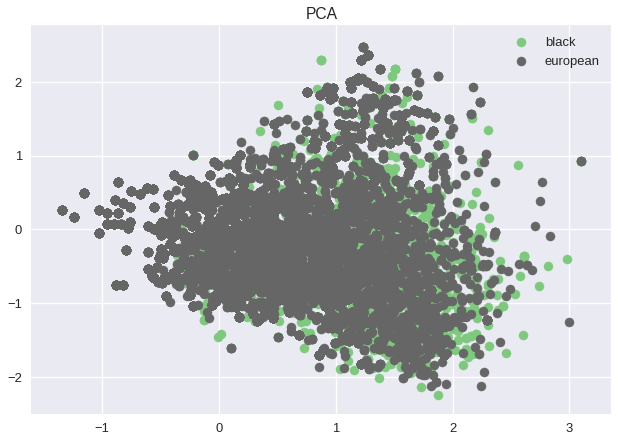

In [0]:

do_plot(PCA(n_components=2).fit_transform(cn_embeddings), 'PCA' , labels =['european', 'black']*35000)